In [4]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

#from matplotlib import pyplot
import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [5]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

In [6]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [7]:
def print_confusion_matrix(tn, fp, fn, tp):
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("---------------------------------------")

In [8]:
def format(val, pos):
    if val == 0:
        return "BULL"
    if val == 1:
        return "BEAR"
    else:
        return ""

In [9]:
def plot(real, imputed):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(50))
    ax.plot(real.index, real, '-', label="Real Data", color='blue')
    ax.plot(real.index, imputed, '-', label="Imputed Data", color='red')
    ax.legend(['Real Data', 'Predicted Data'])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format))
    ax.set_ylim(-0.1, 1.1)
    fig.autofmt_xdate()
    plt.show()

## XGBoost


_______________________________________
______________Training_________________
F1 score 0.8571428571428571
     True False
True    369    120
False   3    290
_______________________________________
---------------------------------------
_______________Testing_________________
F1 score 0.7121212121212122
     True False
True    47    21
False   17    186
_______________________________________
---------------------------------------
---------------------------------------


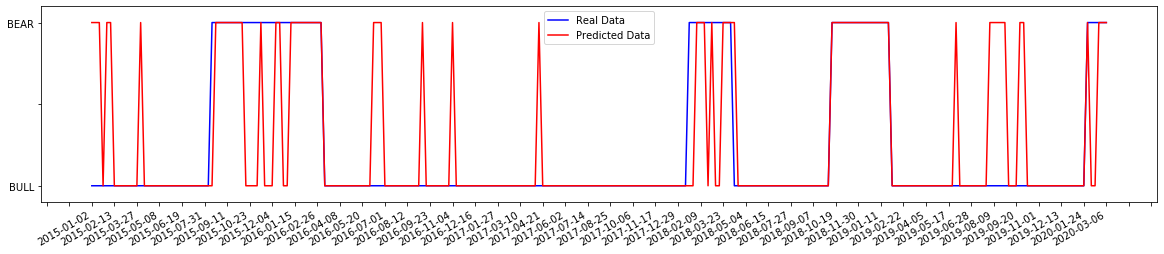

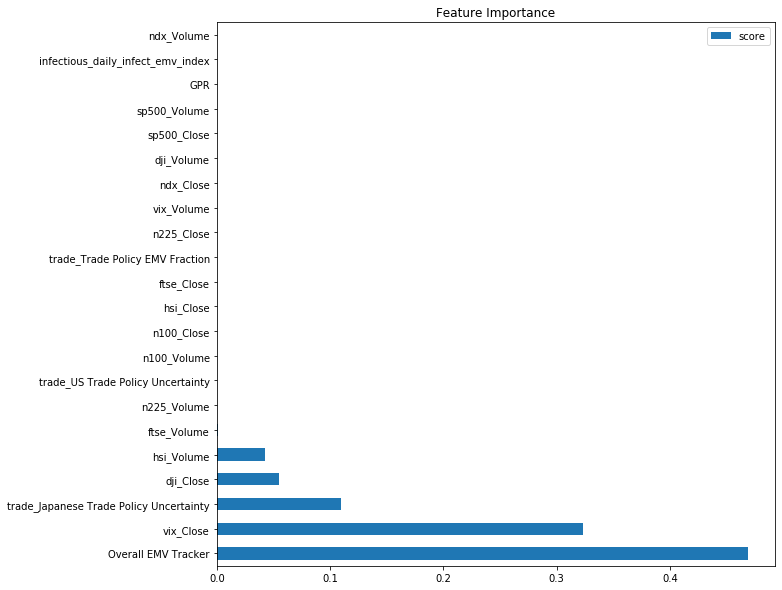

In [10]:
X_train = read_csv('output/\CompleteIndexesWeeklyTrain_0.csv')
X_test = read_csv('output/\CompleteIndexesWeeklyTest_0.csv')['2015-01-02':'2020-03-06']
X_test = X_test[['trade_Trade Policy EMV Fraction', 'vix_Volume', 'infectious_daily_infect_emv_index', 'GPR', 'sp500_Volume', 'Overall EMV Tracker', 'sp500_Close', 'vix_Close', 'dji_Close', 'dji_Volume', 'ndx_Close', 'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume', 'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume', 'trade_US Trade Policy Uncertainty', 'trade_Japanese Trade Policy Uncertainty']]
y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
y.index = y['date'].values
y = y[['regime']]
y = y['regime']=='BEAR'
y = pd.DataFrame (y, columns = ['regime'])

y_train = y.loc['2000-01-01':'2015-01-01']
y_test = y.loc['2015-01-02':'2020-03-06']

best_params = {'colsample_bytree': 0.9, 
               'gamma': 1, 
               'learning_rate': 0.0001,
               'max_delta_step': 2,
               'max_depth': 3, 
               'min_child_weight': 50, 
               'n_estimators': 45, 
               'reg_alpha': 1e-01, 
               'scale_pos_weight':6, 
               'subsample': 0.8}

xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                  eval_metric = 'auc',
                                  learning_rate=best_params['learning_rate'], 
                                  n_estimators=best_params['n_estimators'], 
                                  min_child_weight=best_params['min_child_weight'], 
                                  gamma=best_params['gamma'],
                                  max_delta_step=best_params['max_delta_step'],
                                  max_depth=best_params['max_depth'],
                                  subsample=best_params['subsample'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  reg_alpha=best_params['reg_alpha']
                              )
model = xgb_model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print("_______________________________________")
print("______________Training_________________")
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)  
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("_______________Testing_________________")
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("---------------------------------------")

#plot bear bull imputed and real
plot(y_test, y_pred)
# feature importance
data = pd.DataFrame(data=xgb_model.feature_importances_, index=X_train.columns, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', title="Feature Importance", figsize=(10,10))


In [17]:
def format(val, pos):
    if val == 0:
        return "BULL"
    if val == 1:
        return "BEAR"
    else:
        return ""

In [18]:
def plot(real, imputed):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(50))
    ax.plot(real.index, real, '-', label="Real Data", color='blue')
    ax.plot(real.index, imputed, '-', label="Imputed Data", color='red')
    ax.legend(['Real Data', 'Predicted Data'])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format))
    ax.set_ylim(-0.1, 1.1)
    fig.autofmt_xdate()
    plt.show()

In [19]:
def run_experiment_multiple_times(best_params, n=30):
    result_dict = {}
    result_dict= {'f1':0, 'tn':0, 'fp':0, 'fn':0, 'tp':0, 'auc':0, 'best_f1':0, 'best_model':None, 'best_f1':0, 'best_tn':0, 'best_fp':0, 'best_fn':0, 'best_tp':0}
    list_f1 = []
    for i in range(0,n):
        y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
        y.index = y['date'].values
        y = y[['regime']]
        y = y['regime']=='BEAR'
        y = pd.DataFrame (y, columns = ['regime'])

        y_train = y.loc['2000-01-01':'2015-01-01']
        y_test = y.loc['2015-01-02':'2020-03-06']
        
        X_train = read_csv('output/\CompleteIndexesWeeklyTrain_'+str(i)+'.csv')
        X_train = X_train[['trade_Trade Policy EMV Fraction', 'vix_Volume', 'infectious_daily_infect_emv_index', 'GPR', 'sp500_Volume', 'Overall EMV Tracker', 'sp500_Close', 'vix_Close', 'dji_Close', 'dji_Volume', 'ndx_Close', 'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume', 'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume', 'trade_US Trade Policy Uncertainty', 'trade_Japanese Trade Policy Uncertainty']]
        X_test = read_csv('output/\CompleteIndexesWeeklyTest_'+str(i)+'.csv')['2015-01-02':'2020-03-06']
        X_test = X_test[['trade_Trade Policy EMV Fraction', 'vix_Volume', 'infectious_daily_infect_emv_index', 'GPR', 'sp500_Volume', 'Overall EMV Tracker', 'sp500_Close', 'vix_Close', 'dji_Close', 'dji_Volume', 'ndx_Close', 'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume', 'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume', 'trade_US Trade Policy Uncertainty', 'trade_Japanese Trade Policy Uncertainty']]
        balance = np.sqrt(len(y_train[y_train['regime']==False])/len(y_train[y_train['regime']==True]))
        xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                          learning_rate=best_params['learning_rate'], 
                                          n_estimators=best_params['n_estimators'], 
                                          min_child_weight=best_params['min_child_weight'], 
                                          gamma=best_params['gamma'],
                                          max_delta_step=best_params['max_delta_step'],
                                          max_depth=best_params['max_depth'],
                                          subsample=best_params['subsample'],
                                          scale_pos_weight=best_params['scale_pos_weight'],
                                          colsample_bytree=best_params['colsample_bytree'],
                                          reg_alpha=best_params['reg_alpha']
                                      )

        model = xgb_model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f_score = (2*precision*recall/(precision+recall))
        print('Round', i, "f1", f_score)
        list_f1.append(f_score)
        result_dict['f1'] += f_score
        result_dict['tn'] += tn
        result_dict['fp'] += fp
        result_dict['fn'] += fn
        result_dict['tp'] += tp
        if result_dict['best_f1'] < f_score:
            result_dict['best_f1'] = f_score
            result_dict['best_model'] = model
            result_dict['best_tn'] = tn
            result_dict['best_fp'] = fp
            result_dict['best_fn'] = fn
            result_dict['best_tp'] = tp
    print("STD f1", np.std(list_f1, axis=0))
    result_dict['f1'] = result_dict['f1']/n
    result_dict['tn'] = result_dict['tn']/n
    result_dict['fp'] = result_dict['fp']/n
    result_dict['fn'] = result_dict['fn']/n
    result_dict['tp'] = result_dict['tp']/n
        
    return result_dict     

In [20]:
result_dict = run_experiment_multiple_times(best_params, n=30)

Round 0 f1 0.7121212121212122
Round 1 f1 0.7007299270072993
Round 2 f1 0.7007299270072993
Round 3 f1 0.7007299270072993
Round 4 f1 0.7007299270072993
Round 5 f1 0.7007299270072993
Round 6 f1 0.7007299270072993
Round 7 f1 0.7007299270072993
Round 8 f1 0.7007299270072993
Round 9 f1 0.7007299270072993
Round 10 f1 0.7007299270072993
Round 11 f1 0.7007299270072993
Round 12 f1 0.7007299270072993
Round 13 f1 0.7007299270072993
Round 14 f1 0.7007299270072993
Round 15 f1 0.7007299270072993
Round 16 f1 0.7007299270072993
Round 17 f1 0.7007299270072993
Round 18 f1 0.7007299270072993
Round 19 f1 0.7007299270072993
Round 20 f1 0.7007299270072993
Round 21 f1 0.7007299270072993
Round 22 f1 0.7007299270072993
Round 23 f1 0.7007299270072993
Round 24 f1 0.7007299270072993
Round 25 f1 0.7007299270072993
Round 26 f1 0.7007299270072993
Round 27 f1 0.7007299270072993
Round 28 f1 0.7007299270072993
Round 29 f1 0.7007299270072993
STD f1 0.0020447982567826212


In [21]:
result_dict

{'f1': 0.7011096365110958,
 'tn': 182.13333333333333,
 'fp': 24.866666666666667,
 'fn': 16.033333333333335,
 'tp': 47.96666666666667,
 'auc': 0,
 'best_f1': 0.7121212121212122,
 'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, gamma=1, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.0001, max_delta_step=2, max_depth=3,
               min_child_weight=50, missing=nan, monotone_constraints='()',
               n_estimators=45, n_jobs=0, num_parallel_tree=1, random_state=0,
               reg_alpha=0.1, reg_lambda=1, scale_pos_weight=6, subsample=0.8,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'best_tn': 186,
 'best_fp': 21,
 'best_fn': 17,
 'best_tp': 47}

In [22]:
print("Average F1 Score", result_dict['f1'])
print_confusion_matrix(result_dict['tn'], result_dict['fp'], result_dict['fn'], result_dict['tp'])
print("_______________________________________________________________________________")
print("Best F1 Score", result_dict['best_f1'])
print_confusion_matrix(result_dict['best_tn'], result_dict['best_fp'], result_dict['best_fn'], result_dict['best_tp'])
print("_______________________________________________________________________________")

Average F1 Score 0.7011096365110958
     True False
True    47.96666666666667    24.866666666666667
False   16.033333333333335    182.13333333333333
_______________________________________
---------------------------------------
_______________________________________________________________________________
Best F1 Score 0.7121212121212122
     True False
True    47    21
False   17    186
_______________________________________
---------------------------------------
_______________________________________________________________________________
